In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,InputLayer
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler


2024-07-19 17:38:49.220463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 17:38:49.220620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 17:38:49.347742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_train = pd.read_csv("/kaggle/input/practice/train_set.csv")
df_val = pd.read_csv("/kaggle/input/practice/val_set.csv")
df_test = pd.read_csv("/kaggle/input/practice/test_set.csv")

In [3]:
df_train.index = pd.to_datetime(df_train['date_time_IST'],format = '%d-%m-%Y %H:%M')
df_test.index = pd.to_datetime(df_test['date_time_IST'],format = '%d-%m-%Y %H:%M')
df_val.index = pd.to_datetime(df_val['date_time_IST'],format = '%d-%m-%Y %H:%M')

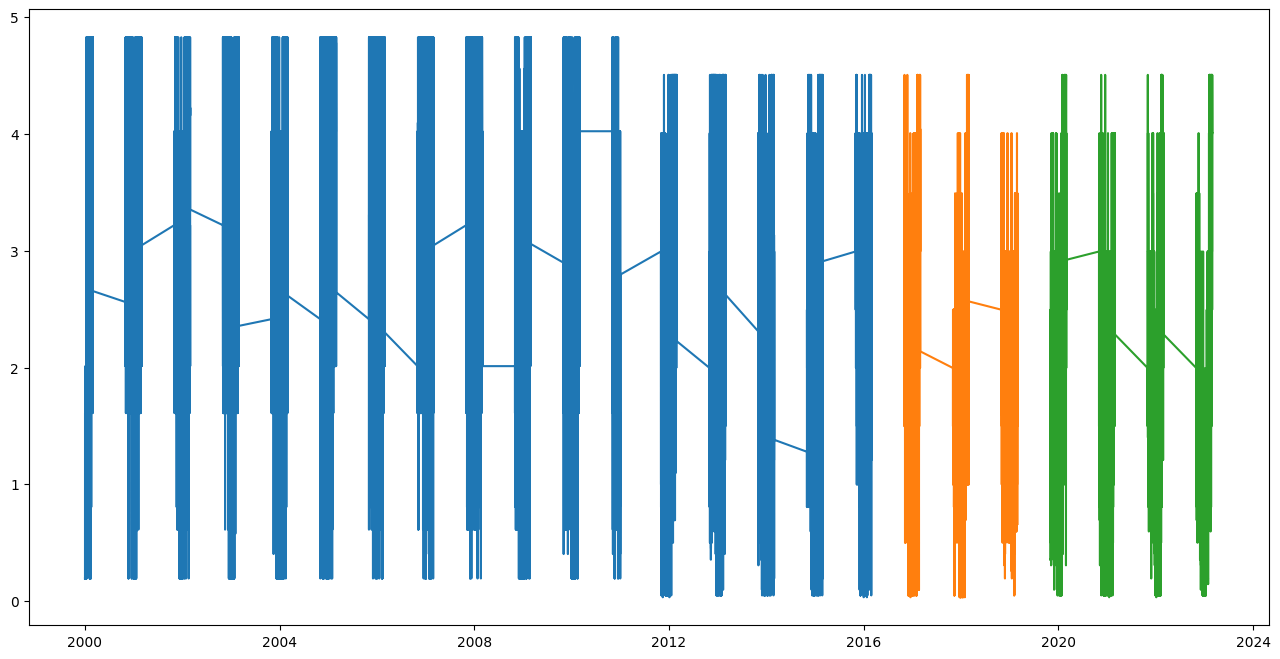

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df_train['3hr_vsby_km'])
plt.plot(df_val['3hr_vsby_km'])
plt.plot(df_test['3hr_vsby_km'])


In [5]:
'''removing only the date_time_IST column and keeping everything else'''
df_train = df_train.drop(columns=['30min_fog', '1hr_fog', '1.5hr_fog', '2hr_fog',
       '2.5hr_fog', '3hr_fog', '6hr_fog', '30min_fog_type', '1hr_fog_type',
       '1.5hr_fog_type', '2hr_fog_type', '2.5hr_fog_type', '3hr_fog_type',
       '6hr_fog_type', '3hr_onset_cond','date_time_IST','30min_vsby_km', '1hr_vsby_km', '1.5hr_vsby_km',
       '2hr_vsby_km', '2.5hr_vsby_km', '6hr_vsby_km'])
df_test = df_test.drop(columns=['30min_fog', '1hr_fog', '1.5hr_fog', '2hr_fog',
       '2.5hr_fog', '3hr_fog', '6hr_fog', '30min_fog_type', '1hr_fog_type',
       '1.5hr_fog_type', '2hr_fog_type', '2.5hr_fog_type', '3hr_fog_type',
       '6hr_fog_type', '3hr_onset_cond','date_time_IST','30min_vsby_km', '1hr_vsby_km', '1.5hr_vsby_km',
       '2hr_vsby_km', '2.5hr_vsby_km', '6hr_vsby_km'])
df_val = df_val.drop(columns=['30min_fog', '1hr_fog', '1.5hr_fog', '2hr_fog',
       '2.5hr_fog', '3hr_fog', '6hr_fog', '30min_fog_type', '1hr_fog_type',
       '1.5hr_fog_type', '2hr_fog_type', '2.5hr_fog_type', '3hr_fog_type',
       '6hr_fog_type', '3hr_onset_cond','date_time_IST','30min_vsby_km', '1hr_vsby_km', '1.5hr_vsby_km',
       '2hr_vsby_km', '2.5hr_vsby_km', '6hr_vsby_km'])
# df_train = df_train.drop(columns=['date_time_IST'])
# df_test = df_test.drop(columns=['date_time_IST'])
# df_val = df_val.drop(columns=['date_time_IST'])

In [6]:
print(df_train.columns)
print(len(df_train.columns))

Index(['tmpc', 'dwpc', 'relh', 'drct', 'wspeedkm', 'pressure', 'vsbykm',
       'feelc', 'cos_min_time', 'sin_min_time', 'fog_time', 'fog_month',
       'diff_tempc_dwpc', '3hr_vsby_km'],
      dtype='object')
14


In [7]:
df_train.head()

,tmpc,dwpc,relh,drct,wspeedkm,pressure,vsbykm,feelc,cos_min_time,sin_min_time,fog_time,fog_month,diff_tempc_dwpc,3hr_vsby_km
date_time_IST,,,,,,,,,,,,,,
2000-01-01 00:00:00,10.0,10.0,100.0,0.0,0.0,101693.2917,0.193121,10.0,1.000000,0.000000,1,1,0.0,0.193121
2000-01-01 00:30:00,10.0,10.0,100.0,0.0,0.0,101693.2917,0.193121,10.0,0.991077,0.133287,1,1,0.0,0.193121
2000-01-01 01:00:00,10.0,10.0,100.0,0.0,0.0,101693.2917,0.193121,10.0,0.964469,0.264195,1,1,0.0,0.193121
2000-01-01 01:30:00,10.0,10.0,100.0,0.0,0.0,101667.8938,0.193121,10.0,0.920650,0.390389,1,1,0.0,0.193121
2000-01-01 02:30:00,10.0,10.0,100.0,0.0,0.0,101617.0979,0.193121,10.0,0.784799,0.619750,1,1,0.0,0.193121


In [8]:
#scaling the data
scaler = MinMaxScaler()
scaler.fit(df_train)
train_data_scaled = scaler.transform(df_train)
val_data_scaled = scaler.transform(df_val)
test_data_scaled = scaler.transform(df_test)

In [9]:
#preparing the data for lstm by sequencing
def df_to_X_y(df,window_size=48):
    df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = df_as_np[i:i + window_size, :13]
        X.append(row)
        label = df_as_np[i+window_size][13]
        y.append(label)

    return np.array(X),np.array(y)
X_train,y_train = df_to_X_y(train_data_scaled)
X_val,y_val = df_to_X_y(val_data_scaled)
X_test,y_test=df_to_X_y(test_data_scaled)
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape


((78843, 48, 13),
 (78843,),
 (16340, 48, 13),
 (16340,),
 (22014, 48, 13),
 (22014,))

In [10]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((78843, 48, 13),
 (78843,),
 (16340, 48, 13),
 (16340,),
 (22014, 48, 13),
 (22014,))

In [19]:
#Vanilla LSTM model 
modelv = Sequential()
modelv.add(InputLayer((48, 13)))
modelv.add(LSTM(128))
modelv.add(Dense(1,activation = 'relu'))
modelv.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError(),
    metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanSquaredError()]
)

checkpoint_callback = ModelCheckpoint('best_model.keras',save_best_only = True,monitor = 'val_loss',mode = 'min')

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True
)
history = modelv.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0590 - mean_absolute_error: 0.1400 - mean_squared_error: 0.0590 - root_mean_squared_error: 0.2152 - val_loss: 0.0096 - val_mean_absolute_error: 0.0751 - val_mean_squared_error: 0.0097 - val_root_mean_squared_error: 0.0980
Epoch 2/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0171 - mean_absolute_error: 0.1005 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0151 - val_mean_absolute_error: 0.0941 - val_mean_squared_error: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 3/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0165 - mean_absolute_error: 0.0982 - mean_squared_error: 0.0165 - root_mean_squared_error: 0.1286 - val_loss: 0.0096 - val_mean_absolute_error: 0.0752 - val_mean_squared_error: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 4/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0160 - mean_absolute_error: 0.0963 - mean_squared_error: 0.0160 - root_mean_sq

688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


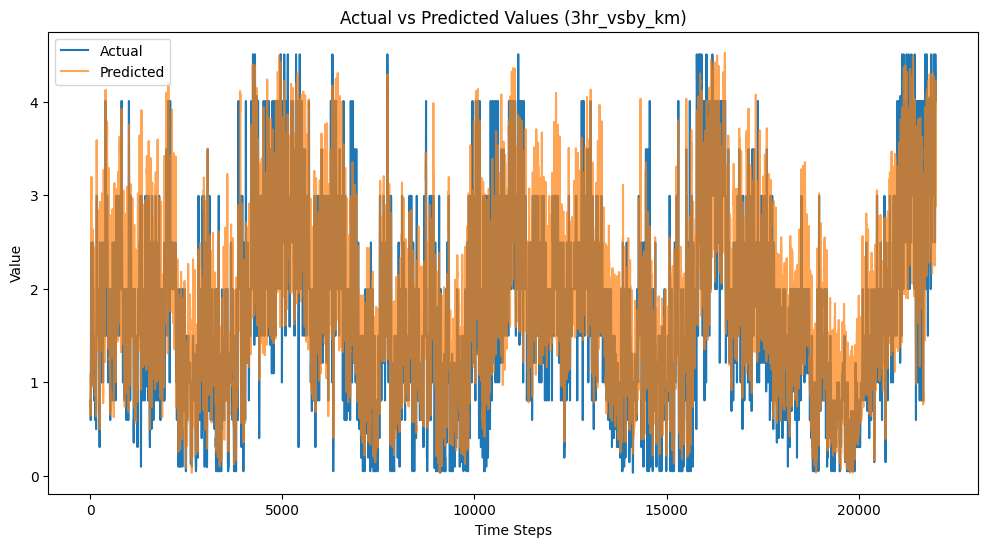

In [20]:
scalervsby = MinMaxScaler()
scalervsby.fit(df_train.iloc[:, 13].values.reshape(-1, 1))

# Perform predictions and inverse transformations
predictions = modelv.predict(X_test)
predictions_inverse = scalervsby.inverse_transform(predictions)

y_test = y_test.reshape(-1, 1)  # Reshape to (n_samples, 1)
y_test_inverse = scalervsby.inverse_transform(y_test)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual',)
plt.plot(predictions_inverse, label='Predicted',alpha = 0.7)
plt.title('Actual vs Predicted Values (3hr_vsby_km)')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [23]:
rmse = np.sqrt(mean_squared_error(y_test_inverse,predictions_inverse))
mae = mean_absolute_error(y_test_inverse,predictions_inverse)
r2 = r2_score(y_test_inverse,predictions_inverse)
print("test-rmse: ",rmse)
print('test-mae:',mae)
print('test-r2_score: ',r2)

test-rmse:  0.46597573223487415
test-mae: 0.36216331916069355
test-r2_score:  0.774782599573007


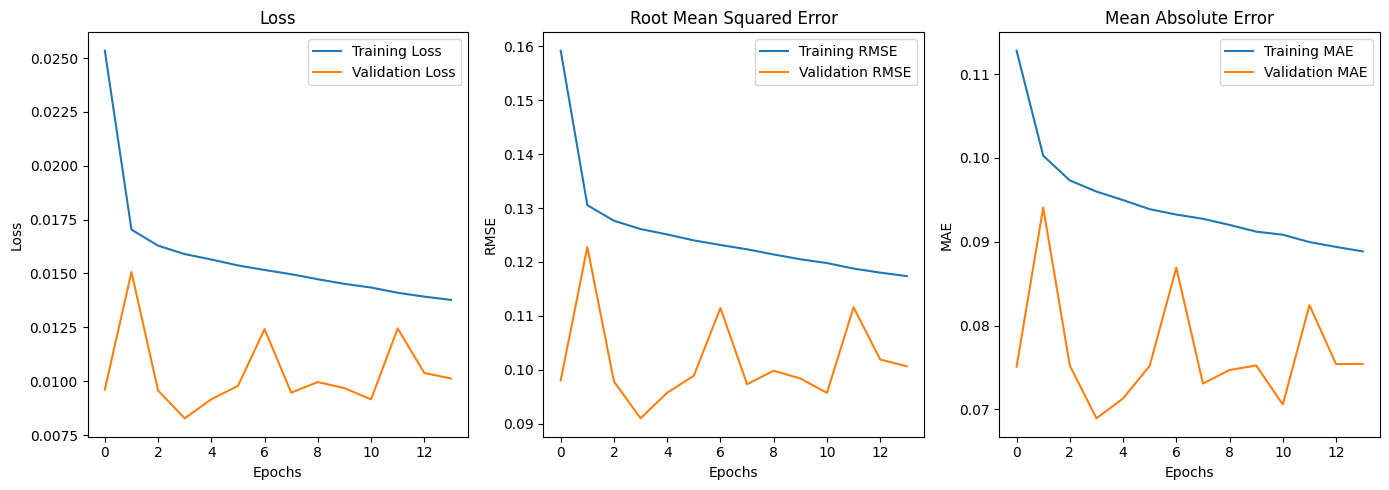

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()